# Fashion-MNIST classification

In [1]:
import time

import numpy as np
import torch
import torchvision
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix

In [2]:
plt.rcParams.update({'font.size': 12})

In [3]:
classes = [
    'top', 'trousers', 'pullover', 'dress', 'coat',
    'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']

In [4]:
data_set = torchvision.datasets.FashionMNIST(
    root='../data/fashion-mnist',
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.FashionMNIST(
        root='../data/fashion-mnist',
        train=True,
        download=True,
        transform=torchvision.transforms.ToTensor()),
    batch_size=250,
    shuffle=True)
val_loader = torch.utils.data.DataLoader(
    torch.utils.data.Subset(data_set, list(range(5000))),
    batch_size=250)
test_loader = torch.utils.data.DataLoader(
    torch.utils.data.Subset(data_set, list(range(5000, 10000))),
    batch_size=250)

In [5]:
x = np.array(train_loader.dataset.train_data)
y = np.array(train_loader.dataset.train_labels)

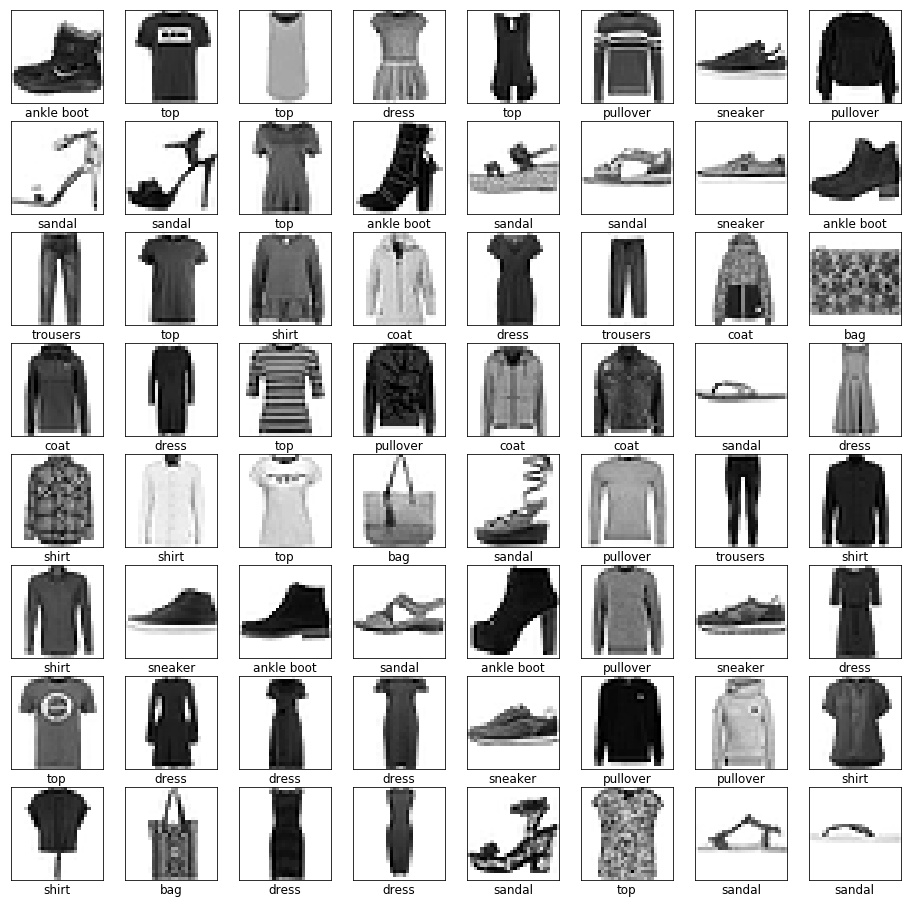

In [6]:
plt.figure(figsize=(16, 16))
for i in range(64):
    plt.subplot(8, 8, i + 1)
    plt.imshow(x[i], cmap=plt.cm.binary)
    plt.xlabel(classes[y[i]])
    plt.xticks([])
    plt.yticks([])
plt.show()

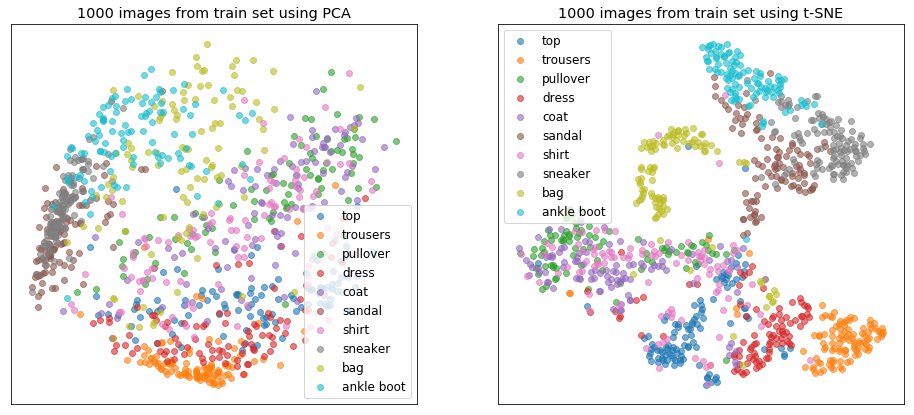

In [7]:
plt.figure(figsize=(16, 7))
for i, (algorithm_name, algorithm) in enumerate([
        ('PCA', PCA(n_components=2)), ('t-SNE', TSNE(n_components=2))]):
    x_reduced = algorithm.fit_transform(x[:1000].reshape(-1, 784))
    y_reduced = y[:1000]
    data = [(class_, x_reduced[y_reduced == i]) for i, class_ in enumerate(classes)]
    
    plt.subplot(1, 2, i + 1)
    for class_, points in data:
        plt.scatter(points[:, 0], points[:, 1], alpha=0.6, label=class_)
    plt.title(f'1000 images from train set using {algorithm_name}')
    plt.legend()
    plt.xticks([])
    plt.yticks([])
plt.show()

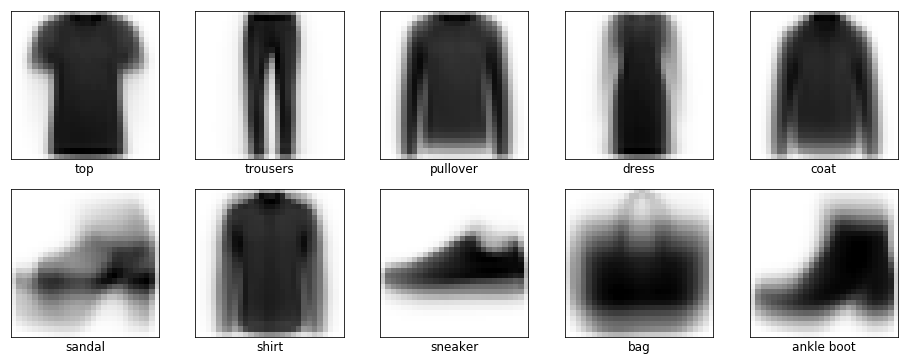

In [8]:
centroids = [(class_, np.mean(x[y == i], axis=0)) for i, class_ in enumerate(classes)]

plt.figure(figsize=(16, 6))
for i, (class_, image) in enumerate(centroids):
    plt.subplot(2, 5, i + 1)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(class_)
    plt.xticks([])
    plt.yticks([])
plt.show()

In [9]:
def plot_history(history):
    plt.figure(figsize=(16, 5))
    for i, (name, key) in enumerate([('accuracy', 'acc'), ('loss', 'loss')]):
        plt.subplot(1, 2, i + 1)
        plt.plot(history['epoch'], history[key], label=f'training {name}')
        plt.plot(history['epoch'], history[f'val_{key}'], label=f'validation {name}')
        plt.title(f'{name} during training')
        plt.legend()
        plt.xlabel('epoch')
        plt.ylabel(name)
    plt.show()


def plot_confusion_matrix(cm, classes=classes):
    plt.figure(figsize=(7, 7))
    plt.imshow(cm, cmap=plt.cm.binary)
    threshold = np.max(cm) / 2
    for i in range(len(classes)):
        for j in range(len(classes)):
            plt.text(
                j, i, cm[i, j], color='white' if cm[i, j] > threshold else 'black',
                horizontalalignment='center', verticalalignment='center')
    plt.title('confusion matrix')
    plt.xlabel('predicted class')
    plt.xticks(range(len(classes)), classes, rotation=90)
    plt.ylabel('true class')
    plt.yticks(range(len(classes)), classes)
    plt.show()

In [10]:
class Classifier(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def fit(self, train_loader, val_loader, epochs):
        self.to(self.device)
        history = {'epoch': [], 'loss': [], 'acc': [], 'val_loss': [], 'val_acc': []}
        for epoch in range(1, epochs+1):
            self.train()
            start_time = time.time()
            loss, acc = 0, 0
            for data, target in train_loader:
                # Batch training step
                self.optimizer.zero_grad()
                data, target = data.to(self.device), target.to(self.device)
                output = self(data)
                loss_ = self.loss(output, target)
                loss_.backward()
                self.optimizer.step()
                # Calculate metrics for batch
                loss += float(loss_) * len(data)
                acc += int((output.argmax(dim=1) == target).sum())
            # Calculate metrics for epoch
            loss /= len(train_loader.dataset)
            acc /= len(train_loader.dataset)
            val_loss, val_acc = self.evaluate(val_loader)
            duration = time.time() - start_time
            # Save training history
            history['epoch'].append(epoch)
            history['loss'].append(loss)
            history['acc'].append(acc)
            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc)
            print(
                f'[{epoch:{len(str(epochs))}}/{epochs}] {duration:.1f}s'
                f' - loss: {loss:.4f} - acc: {acc:.4f}'
                f' - val_loss: {val_loss:.4f} - val_acc: {val_acc:.4f}')
        return history

    def evaluate(self, data_loader):
        self.to(self.device)
        self.eval()
        loss, acc = 0, 0
        for data, target in data_loader:
            data, target = data.to(self.device), target.to(self.device)
            output = self(data)
            loss += float(self.loss(output, target)) * len(data)
            acc += int((output.argmax(dim=1) == target).sum())
        loss /= len(data_loader.dataset)
        acc /= len(data_loader.dataset)
        return loss, acc

    def predict(self, data_loader):
        self.to(self.device)
        self.eval()
        prediction, target = [], []
        for data, target_ in data_loader:
            data = data.to(self.device)
            prediction.extend(self(data).argmax(dim=1).cpu())
            target.extend(target_)
        return np.array(target), np.array(prediction)

In [11]:
class MultilayerPerceptron(Classifier):

    def __init__(self):
        super().__init__()
        self.layers = torch.nn.ModuleList([
            torch.nn.Dropout(0.25),
            torch.nn.Linear(784, 150),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.25),
            torch.nn.Linear(150, 10),
            # torch.nn.Softmax(dim=1)
        ])
        
        self.loss = torch.nn.functional.cross_entropy
        self.optimizer = torch.optim.Adam(self.parameters())

    def forward(self, x):
        x = x.view(x.size()[0], -1)
        for layer in self.layers:
            x = layer(x)
        return x

In [12]:
model = MultilayerPerceptron()

In [13]:
history = model.fit(train_loader, val_loader, epochs=50)

[ 1/50] 4.1s - loss: 0.7282 - acc: 0.7490 - val_loss: 0.5153 - val_acc: 0.8178
[ 2/50] 4.1s - loss: 0.5084 - acc: 0.8203 - val_loss: 0.4510 - val_acc: 0.8396
[ 3/50] 4.0s - loss: 0.4611 - acc: 0.8347 - val_loss: 0.4169 - val_acc: 0.8564
[ 4/50] 3.9s - loss: 0.4319 - acc: 0.8450 - val_loss: 0.4044 - val_acc: 0.8598
[ 5/50] 3.9s - loss: 0.4123 - acc: 0.8498 - val_loss: 0.3972 - val_acc: 0.8592
[ 6/50] 3.9s - loss: 0.3994 - acc: 0.8547 - val_loss: 0.3839 - val_acc: 0.8594
[ 7/50] 3.9s - loss: 0.3889 - acc: 0.8570 - val_loss: 0.3710 - val_acc: 0.8652
[ 8/50] 3.9s - loss: 0.3810 - acc: 0.8613 - val_loss: 0.3586 - val_acc: 0.8676
[ 9/50] 4.1s - loss: 0.3722 - acc: 0.8656 - val_loss: 0.3630 - val_acc: 0.8676
[10/50] 4.1s - loss: 0.3647 - acc: 0.8668 - val_loss: 0.3522 - val_acc: 0.8732
[11/50] 4.2s - loss: 0.3596 - acc: 0.8683 - val_loss: 0.3471 - val_acc: 0.8750
[12/50] 3.9s - loss: 0.3539 - acc: 0.8690 - val_loss: 0.3471 - val_acc: 0.8724
[13/50] 3.9s - loss: 0.3498 - acc: 0.8717 - val_loss

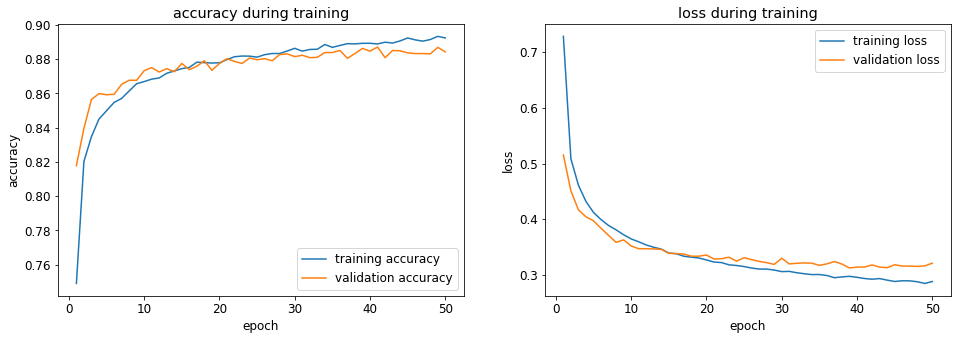

In [14]:
plot_history(history)

In [15]:
print(
    'Accuracy:\n'
    f'  - train set:      {100 * model.evaluate(train_loader)[1]:.2f}%\n'
    f'  - validation set: {100 * model.evaluate(val_loader)[1]:.2f}%\n'
    f'  - test set:       {100 * model.evaluate(test_loader)[1]:.2f}%')

Accuracy:
  - train set:      91.82%
  - validation set: 88.42%
  - test set:       89.12%


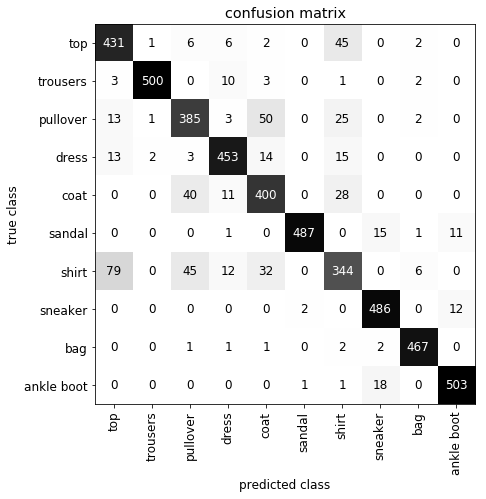

In [16]:
cm = confusion_matrix(*model.predict(test_loader))
plot_confusion_matrix(cm)

In [17]:
class ConvolutionalNet(Classifier):

    def __init__(self):
        super().__init__()
        self.conv_layers = torch.nn.ModuleList([
            torch.nn.Conv2d(1, 32, 5),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(32, 64, 5),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(64, 128, 1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
        ])
        self.dense_layers = torch.nn.ModuleList([
            torch.nn.Dropout(0.5),
            torch.nn.Linear(512, 150),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(150, 10),
            # torch.nn.Softmax(dim=1),
        ])

        self.loss = torch.nn.functional.cross_entropy
        self.optimizer = torch.optim.Adam(self.parameters())

    def forward(self, x):
        for layer in self.conv_layers:
            x = layer(x)
        x = x.view(x.size()[0], -1)
        for layer in self.dense_layers:
            x = layer(x)
        return x

In [18]:
model = ConvolutionalNet()

In [19]:
history = model.fit(train_loader, val_loader, epochs=50)

[ 1/50] 6.6s - loss: 0.8964 - acc: 0.6712 - val_loss: 0.5581 - val_acc: 0.7708
[ 2/50] 6.1s - loss: 0.5558 - acc: 0.7911 - val_loss: 0.4617 - val_acc: 0.8252
[ 3/50] 6.0s - loss: 0.4824 - acc: 0.8230 - val_loss: 0.4103 - val_acc: 0.8468
[ 4/50] 6.0s - loss: 0.4360 - acc: 0.8409 - val_loss: 0.3739 - val_acc: 0.8624
[ 5/50] 6.0s - loss: 0.3999 - acc: 0.8545 - val_loss: 0.3519 - val_acc: 0.8716
[ 6/50] 6.0s - loss: 0.3783 - acc: 0.8621 - val_loss: 0.3377 - val_acc: 0.8734
[ 7/50] 6.0s - loss: 0.3608 - acc: 0.8695 - val_loss: 0.3465 - val_acc: 0.8672
[ 8/50] 6.0s - loss: 0.3460 - acc: 0.8753 - val_loss: 0.3132 - val_acc: 0.8854
[ 9/50] 5.9s - loss: 0.3280 - acc: 0.8808 - val_loss: 0.3162 - val_acc: 0.8790
[10/50] 6.0s - loss: 0.3190 - acc: 0.8848 - val_loss: 0.3077 - val_acc: 0.8852
[11/50] 6.2s - loss: 0.3091 - acc: 0.8873 - val_loss: 0.3027 - val_acc: 0.8850
[12/50] 6.1s - loss: 0.3002 - acc: 0.8904 - val_loss: 0.2889 - val_acc: 0.8946
[13/50] 6.0s - loss: 0.2914 - acc: 0.8943 - val_loss

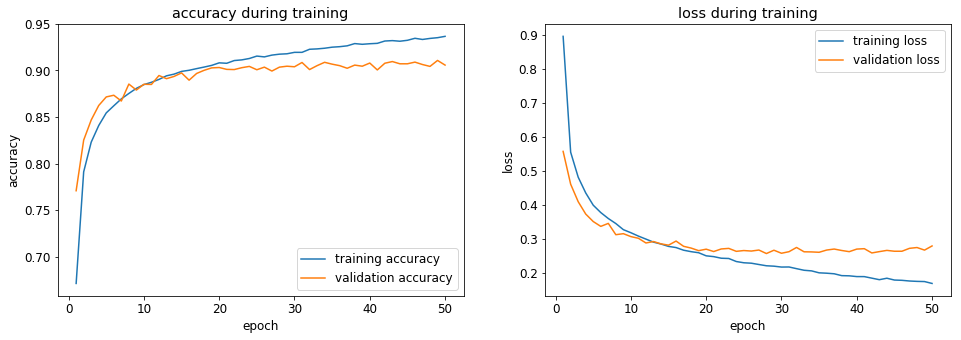

In [20]:
plot_history(history)

In [21]:
print(
    'Accuracy:\n'
    f'  - train set:      {100 * model.evaluate(train_loader)[1]:.2f}%\n'
    f'  - validation set: {100 * model.evaluate(val_loader)[1]:.2f}%\n'
    f'  - test set:       {100 * model.evaluate(test_loader)[1]:.2f}%')

Accuracy:
  - train set:      95.73%
  - validation set: 90.58%
  - test set:       91.20%


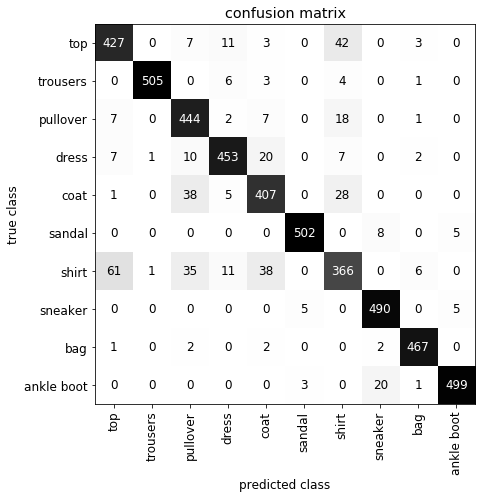

In [22]:
cm = confusion_matrix(*model.predict(test_loader))
plot_confusion_matrix(cm)